In [1]:
import segmentation.unet
import importlib
importlib.reload(segmentation.unet)

C:\Users\s2137314\Anaconda3\envs\gel_env\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


<module 'segmentation.unet' from 'c:\\2022_summer_intern\\automatic-gel-analysis\\backend\\segmentation\\unet\\__init__.py'>

In [2]:
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
import imageio
import cv2
import torchvision.transforms as transforms
import torch
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import DataLoader

from segmentation.unet import UNet, smp_UNetPlusPlus, smp_UNet
from segmentation.helper_functions.display_functions import show_segmentation

In [3]:
# code here modified from https://github.com/milesial/Pytorch-UNet/tree/e36c782fbfc976b7326182a47dd7213bd3360a7e
import logging
from pathlib import Path
import imageio
import cv2
import os
from PIL import Image

import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

from segmentation.helper_functions.general_functions import extract_image_names_from_folder


class BasicDataset(Dataset):
    def __init__(self, images_dir: str, n_channels: int, scale: float = 1.0,
                 augmentations=None, padding: bool = False, image_names=None):
        """
        TODO: fill in documentation
        :param images_dir:
        :param masks_dir:
        :param n_channels:
        :param scale:
        :param mask_suffix:
        :param augmentations:
        :param padding:
        """

        assert (n_channels == 1 or n_channels == 3), 'Dataset number of channels must be either 1 or 3'
        assert 0 < scale <= 1, 'Image scaling must be between 0 and 1'

        self.images_dir = Path(images_dir)
        self.n_channels = n_channels
        self.scale = scale
        self.standard_image_transform = transforms.Compose([transforms.ToTensor()])
        if image_names is not None:
            self.image_names = image_names
        else:
            self.image_names = extract_image_names_from_folder(images_dir)

        self.augmentations = augmentations
        self.padding = padding

        if padding:
            max_dimension = 0
            # loops through provided images and extracts the largest image dimension, for use if padding is selected
            for root, dirs, files in os.walk(self.images_dir):
                for name in files:
                    image_file = os.path.join(root, name)
                    image = imageio.imread(image_file)  # TODO: investigate the warning here...
                    max_dimension = max(max_dimension, image.shape[0], image.shape[1])
            max_dimension = 32 * (max_dimension // 32 + 1)  # to be divisible by 32 TODO: why?

            self.max_dimension = max_dimension

        if not self.image_names:
            raise RuntimeError(f'No images found in {images_dir}, make sure you put your images there')
        logging.info(f'Creating dataset with {len(self.image_names)} examples')

    def __len__(self):
        return len(self.image_names)

    def set_augmentations(self, augmentations):
        self.augmentations = augmentations

    @staticmethod
    def load_image(self, filename, n_channels):
        image = imageio.imread(filename)

        # Converts to desired number of channels
        if n_channels == 1:  # Target input: 1 channel
            if image.shape[-1] == 3:  # Actual input: 3 channels
                image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            elif image.shape[-1] == 4:  # Actual input: 4 channels
                image = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)
            # No change required for already grayscale images
        elif n_channels == 3:  # Target input: 3 channels
            if image.shape[-1] == 4:  # Actual input: 4 channels
                image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
            elif image.shape[-1] != 3:  # Actual input: 1 channels
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        # Normalizing image
        if image.dtype == 'uint8':
            max_val = 255
        elif image.dtype == 'uint16':
            max_val = 65535
        else:
            raise RuntimeError('Image type not recognized.')

        image = image.astype(np.float32) / max_val

        return image

    def __getitem__(self, idx):
        # print('Dataloader is %s, image IDX is: %s, image_name is %s' % ('validation' if not self.augmentations else 'Training', idx, self.image_names[idx]))
        # return np.zeros((5,5))
        img_file = self.image_names[idx]
        
        img_array = self.load_image(self, filename=img_file, n_channels=self.n_channels)

        if self.augmentations:
            sample = self.augmentations(image=img_array, mask=mask_array)
            img_array = sample['image']
            mask_array = sample['mask']

        if self.padding:
            top = (self.max_dimension - img_array.shape[0]) // 2
            bottom = self.max_dimension - img_array.shape[0] - top
            left = (self.max_dimension - img_array.shape[1]) // 2
            right = self.max_dimension - img_array.shape[1] - left

            img_array = np.pad(img_array, pad_width=((top, bottom), (left, right)), mode='constant')

        img_tensor = self.standard_image_transform(img_array)
        
        return img_tensor


In [21]:
def test_net(images_path, n_channels, checkpoint_file_path, net):
    test_set = BasicDataset(images_path, n_channels, padding=True)
    n_test = int(len(test_set))
    test_loader = DataLoader(test_set, shuffle=False, batch_size=1, num_workers=0, pin_memory=True)
    net.train()
    saved_dict = torch.load(f=checkpoint_file_path, map_location=torch.device("cpu"))
    net.load_state_dict(saved_dict['network'])
    # net.load_state_dict(saved_dict)
    print(f'Model loaded from {checkpoint_file_path}')

    fig, ax = plt.subplots(n_test, 3, figsize=(10, 120))

    plot_row = 0
    for image in test_loader:
        with torch.no_grad():
            mask_pred = net(image)
        image = image.squeeze()
        mask_pred.squeeze()


        mask_pred_array = np.transpose(mask_pred.detach().squeeze().cpu().numpy(), (1, 2, 0))  # CHW to HWC
        height, width = mask_pred_array.shape[0], mask_pred_array.shape[1]

        threshold = 0.8
        thresholded = np.zeros((height, width))
        for row in range(height):
            for column in range(width):
                if mask_pred_array[row][column][0] < (1-threshold) and mask_pred_array[row][column][1] > threshold:
                    thresholded[row][column] = 1



        # use a boolean condition to find where pixel values are > 0.75
        blobs = thresholded == 1

        # label connected regions that satisfy this condition
        labels, nlabels = ndimage.label(blobs, structure=[[1,1,1],[1,1,1],[1,1,1]])


        # find their centres of mass. in this case I'm weighting by the pixel values in
        # `img`, but you could also pass the boolean values in `blobs` to compute the
        # unweighted centroids.
        r, c = np.vstack(ndimage.center_of_mass(thresholded, labels, np.arange(nlabels) + 1)).T

        # find their distances from the top-left corner
        d = np.sqrt(r*r + c*c)


        # Get coordinates for each unique band
        # create array of intensities
        volume_labels = np.zeros((nlabels+1), float)
        area_labels = np.zeros((nlabels+1), int)

        for h in range(height):
            for w in range(width):
                volume_labels[labels[h][w]] += image[h][w]  # index = label, value += intensity(between 0 and 1)
                area_labels[labels[h][w]] += 1
        # print(f'(nlabels = {nlabels})\nvolume_labels: {volume_labels}')

    # plot

    # ax[0].imshow(thresholded)
        original_image = image.detach().squeeze().cpu().numpy()
        ax[plot_row][0].imshow(original_image, cmap='gray')

        ax[plot_row][1].imshow(original_image, cmap='gray')
        ax[plot_row][1].imshow(np.ma.masked_array(labels, ~blobs), cmap=plt.cm.rainbow)
#         for ri, ci, di in zip(r, c, d):
#             label = int(labels[int(ri)][int(ci)])
#             ax[plot_row][1].annotate(f'{label}', xy=(ci, ri),  xytext=(0, -5),
#                        textcoords='offset points', ha='center', va='top',
#                        fontsize=8, color='blue')

        ax[plot_row][2].imshow(np.ma.masked_array(labels, ~blobs), cmap=plt.cm.rainbow)
        for ri, ci, di, count in zip(r, c, d, range(nlabels)):
        #     ax[1].annotate('', xy=(0, 0), xytext=(ci, ri),
        #                    arrowprops={'arrowstyle':'<-', 'shrinkA':0})
        #     ax[1].annotate(f'label={label}, concentration={volume_labels[label]}', xy=(ci, ri),  xytext=(0, -5),
        #     textcoords='offset points', ha='center', va='top',
            label = int(labels[int(ri)][int(ci)])
            ax[plot_row][2].annotate(f'{count+1}: V={round(volume_labels[count+1], 1)}', xy=(ci, ri),  xytext=(0, -5),
                                  textcoords='offset points', ha='center', va='top',
                                  fontsize=8)
        plot_row+=1
        
        # TODO: delete
        print(volume_labels)
        
        
        
        break
    for aa in ax.flat:
        aa.set_axis_off()
    fig.tight_layout()
    plt.savefig('C:/Users/s2137314/Downloads/save as pdf.pdf')
    plt.show()

In [24]:
images_path = "C:/2022_Summer_Intern/NEB_Gel_Images"
# checkpoint_file_path = "C:/Users/s2137314/Downloads/checkpoint_epoch450.pth"
# checkpoint_file_path = "C:/Users/s2137314/Downloads/smp-UNet-with-augmentations-checkpoint_epoch300.pth"
# checkpoint_file_path = "C:/2022_Summer_Intern/smp-UNet_No_Augmentations_epoch_180/smp-UNet-no-augmentations-checkpoint_epoch180.pth"
checkpoint_file_path = "C:/2022_Summer_Intern/smp-UNet_No_pretrain_epoch_260_0.8553/smp-UNet_pretrain_imagenet_checkpoint_epoch260.pth"
n_channels = 1
# net = UNet(n_channels=1, n_classes=2, bilinear=False)
net = smp_UNet(
            encoder_name="resnet18",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=2,  # model output channels (number of classes in your dataset)
        )

C:\Users\s2137314\Anaconda3\envs\gel_env\lib\site-packages\ipykernel_launcher.py:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


Model loaded from C:/2022_Summer_Intern/smp-UNet_No_pretrain_epoch_260_0.8553/smp-UNet_pretrain_imagenet_checkpoint_epoch260.pth


C:\Users\s2137314\Anaconda3\envs\gel_env\lib\site-packages\ipykernel_launcher.py:70: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


[1.24168115e+04 3.60000000e+01 1.02000000e+02 2.00000000e+00
 1.51243515e+02 1.81384705e+02 2.27682739e+02 2.09408295e+02
 1.79780548e+02 5.03740875e+02 2.25725952e+02 1.79937195e+02
 1.65827652e+02 2.16014572e+02]


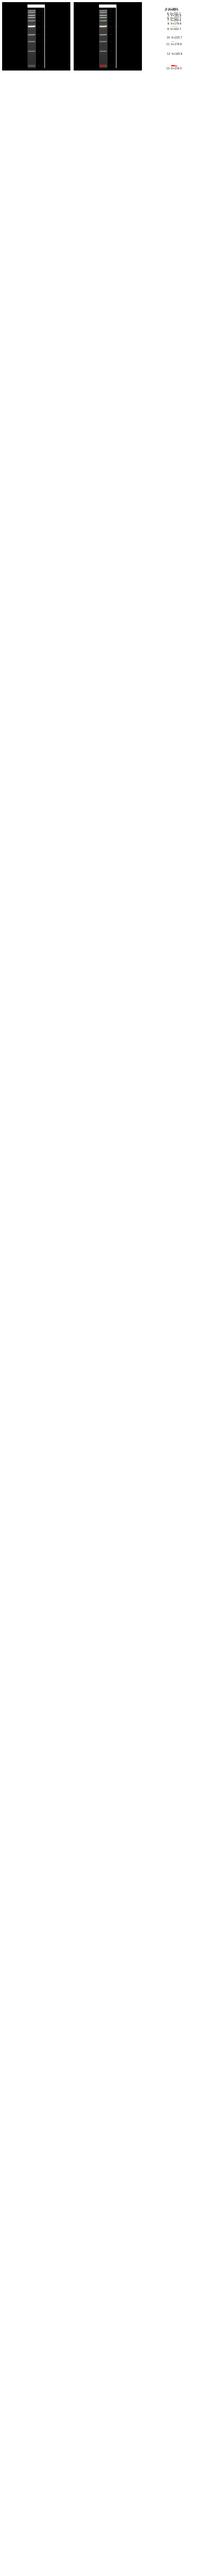

In [25]:
test_net(images_path, n_channels, checkpoint_file_path, net)

In [56]:
real_volumes = []
analyzer_volumes = []
filter_indices = [1, 2, 3, 4, 6, 7, 8, 9, 12, 14]
measured_volumes = volume_labels[filter_indices]

In [57]:
1 2 3 4 5 7 8 9 12 14

SyntaxError: invalid syntax (2222667394.py, line 1)

Real // Measured // GelAnalyzer
[[1.27272727 1.         1.        ]
 [1.27272727 1.19973545 1.0780303 ]
 [1.51515152 1.5026455  1.40454545]
 [1.27272727 1.38492063 1.33257576]
 [1.         1.18915344 1.26287879]
 [3.78787879 3.33134921 2.49924242]
 [1.45454545 1.49272487 1.17575758]
 [1.09090909 1.18981481 1.01590909]
 [1.27272727 1.09656085 0.96818182]
 [1.27272727 1.42857143 1.10984848]]


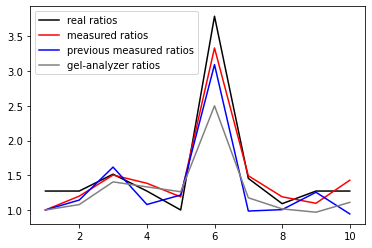

In [28]:
measured_ratios = []
prev_measured_ratios = []
real_ratios = []
analyzer_ratios = []
prev_measured_volumes = [154.4, 176.5, 249.7, 166.6, 187.7, 477.4, 152.1, 155.2, 193.8, 145.7]
measured_volumes = [151.2, 181.4, 227.2, 209.4, 179.8, 503.7, 225.7,179.9, 165.8, 216.0]
real_volumes = [42, 42, 50, 42, 33, 125, 48, 36, 42, 42]
# measured_volumes = volume_labels[1:]
analyzer_volumes = [1320, 1423, 1854, 1759, 1667, 3299, 1552, 1341, 1278, 1465]
base_value_real = 33
prev_base_value_measured = 154.4
base_value_measured = 151.2
base_value_analyzer = 1320

for r, pm, m, a in zip(real_volumes, prev_measured_volumes, measured_volumes, analyzer_volumes):
    real_ratios.append(r/base_value_real)
    prev_measured_ratios.append(pm/prev_base_value_measured)
    measured_ratios.append(m/base_value_measured)
    analyzer_ratios.append(a/base_value_analyzer)
print("Real // Measured // GelAnalyzer")
print(np.c_[real_ratios, measured_ratios, analyzer_ratios])
x = range(1,11)
plt.plot(x, real_ratios, color='black', label='real ratios')
plt.plot(x, measured_ratios, color='red', label='measured ratios')
plt.plot(x, prev_measured_ratios, color='blue', label='previous measured ratios')
plt.plot(x, analyzer_ratios, color='grey', label='gel-analyzer ratios')
plt.legend()


In [40]:
volume_labels[6]

285.1568674445152

In [41]:
volume_labels[7]

342.1803973913193

In [42]:
volume_labels[10]

282.0235332250595

In [47]:
nlabels

14